#    Analysis of the Ritz hotel London reviews extracted from Trip Advisor

Customer online reviews were extracted to understand the experience of customers in order to provide some insights that could improve operational effectiveness. Customer reviews are one of the most important considerations for people when selecting a hotel, therefore it's important to understand how to best leverage this information and draw insights. 

This report is divided into the following:
1. Exploratory Data Analysis
2. Visualisation
3. LDA Topic Modelling 


# 1. Exploratory Data Analysis


In [99]:
import pandas as pd
import numpy as np
import re

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
raw_data = pd.read_csv('tripadvisor_scrape.csv')

In [5]:
raw_data.head()

,profile name,profile contributions,profile helpful votes,review title,rating,review,date of stay,trip category
0,Celene,1,0,Stellar !!,[5.0],Stayed Sunday night 20/09/20.The whole experie...,September 2020,NaN
1,Judes111,251,104,Well done Chef!,[5.0],"Amazing dinner here, attentive waiters and exc...",September 2020,Travelled with family
2,Louise,4,3,Great but not fantastic,[4.0],Stayed for a week I wish there won’t be as muc...,August 2020,Travelled on business
3,Ruby travels,7,4,Afternoon tea treat,[5.0],To celebrate my friends birthday we went to th...,August 2020,Travelled with friends
4,Rachel H,46,39,Everything we hoped for,[5.0],We stayed at The Ritz for one night in a Queen...,September 2020,Travelled as a couple


In [6]:
raw_data.shape

(4415, 8)

In [8]:
#check if there is any missing data
raw_data.isnull().sum()

profile name                0
profile contributions       0
profile helpful votes       0
review title                0
rating                      0
review                      0
date of stay               22
trip category            1818
dtype: int64

There is a significant amount of data missing for trip category and only a small number of data missing regarding date of stay. I will determine if both columns are relevant and if they require imputing missing values.

In [14]:
raw_data.describe()

,profile name,profile contributions,profile helpful votes,review title,rating,review,date of stay,trip category
count,4415,4415,4415,4415,4415,4415,4393,2597
unique,4145,549,296,3610,5,4415,183,5
top,cucuruchito,1,0,Afternoon Tea,[5.0],I booked a suite at the ritz for a surprise en...,December 2015,Travelled as a couple
freq,6,116,167,126,3637,1,80,1328


There are a total of 4415 customer profiles that left a review. Given most of these columns are text based the table above doesn't provide anything insightful.

In [18]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   profile name           4415 non-null   object
 1   profile contributions  4415 non-null   object
 2   profile helpful votes  4415 non-null   object
 3   review title           4415 non-null   object
 4   rating                 4415 non-null   object
 5   review                 4415 non-null   object
 6   date of stay           4393 non-null   object
 7   trip category          2597 non-null   object
dtypes: object(8)
memory usage: 276.1+ KB


In [12]:
#creating a copy of the raw data set
df = raw_data.copy()

In [13]:
# remove brackets found in the ratings column
df['rating'] =  raw_data['rating'].apply(lambda x: x.replace('[','').replace(']','')) 

In [106]:
df.head()

,profile name,profile contributions,profile helpful votes,review title,rating,review,date of stay,trip category
0,Celene,1,0,Stellar !!,5.0,"Stayed Sunday night 20/09/20.The whole experience was magical.Even with Covid changes followed to the max !Beautiful decor,throughout.Fabulous cocktails in the Rivoli bar & the FOOD was delicious.We treated ourselves to the beef Wellington-sublime !The staff are friendly, helpful & discrete.Coming through reception we chanced upon Executive chef Mr. John Williams MBE & head concierge Mr. Michael de Cozar discussing a work issue.I confess to having been overcome at seeing both of these well know people --they stopped discussing what they had to sort out re work and we had a quick chat about the hotel ,kitchen .Such a lovely gesture ,as all guest's are made to feel that nothing is too much trouble or an inconvenience .Afternoon tea was a delight.Do dress up, wear a tie .The Palm court is there to make you feel special! THANK YOU everyone for a lovely stay ---We will be back !!",2020-09-01,NaN
1,Judes111,251,104,Well done Chef!,5.0,"Amazing dinner here, attentive waiters and excellent food. Breakfast also very good. Bedrooms all to Anti Covid standards and very comfortable and all the staff were attentive but unobtrusive. The Italian Garden is well worth a visit for drinks or even afternoon tea.",2020-09-01,Travelled with family
2,Louise,4,3,Great but not fantastic,4.0,"Stayed for a week I wish there won’t be as much dissatisfaction as it was but overall was great as usual. Social distancing in place Thanks to the team for looking after me, all the best Stay safe x L",2020-08-01,Travelled on business
3,Ruby travels,7,4,Afternoon tea treat,5.0,"To celebrate my friends birthday we went to the Ritz for afternoon tea. We had never been before but had always wanted to so were very much looking forward to it. We were not disappointed!! It was an amazing from the moment we entered until leaving. The hotel is beautiful and the decor is superb. The Palm Court were we were served afternoon tea was stunning. All the staff were very welcoming and nothing was to much trouble. The table was beautifully laid and afternoon tea was superb. The sandwiches were made with a variety of breads and fillings, and the waiter does ask if you would like more sandwiches, but we were happy with what we had already been served. The cakes just melted in your mouth, and you just need to let the waiter know when you are ready for the scones as they are served to you warm, with strawberry conserve and clotted cream. They have many different varieties of tea that you can try. I had the Ritz royal blend which was very nice. There was a pianist playing which was lovely and the whole atmosphere made for a great, relaxed afternoon. As it was my friends birthday I ordered a birthday cake for her when making the booking. It was presented to her at the table and was a lovely end to the tea. We really did enjoy our afternoon and will certainly be booking again and maybe try lunch next time. Would definitely recommend to anyone who is thinking of booking this.",2020-08-01,Travelled with friends
4,Rachel H,46,39,Everything we hoped for,5.0,"We stayed at The Ritz for one night in a Queen room (their standard one) and had afternoon tea and cocktails in the bar in the evening. The welcome when we arrived was wonderful- warm, friendly and professional with some nice touches. The room was gorgeous, champagne in the room and lots of complimentary extras- biscuits, chocolate nibbles, with a gift bag in case you want to take them home. Afternoon tea was gorgeous and the service very slick, piano accompaniment was excellent. Rivoli bar was good and an interesting choice of cocktails. The bed was so very comfy and lovely Asprey toiletries. Breakfast the following morning I’m the main restaurant was excellent and the service too. Overall - great experience, worth the price to see how we might live if we won the lottery (!) and the staff were exce

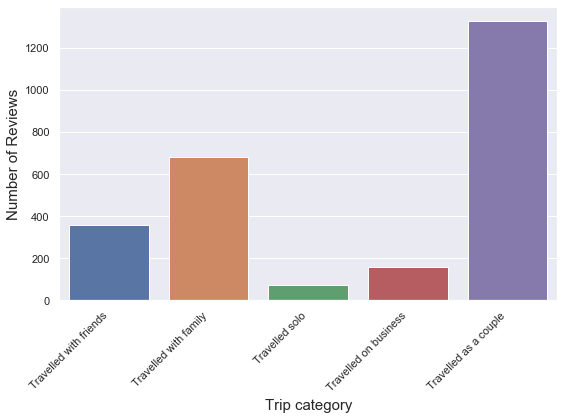

In [152]:
# set size of figure 
plt.figure(figsize=(8,6))
#set colour theme
sns.set_theme(style="darkgrid")
#plot trip categories 
ax = sns.countplot(df['trip category'].sort_values(ascending= False))
#create labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.xlabel('Trip category', size=15)
plt.ylabel('Number of Reviews', size=15)
plt.tight_layout()
plt.show()

Only 58% of the reviews contain information about their reason for travelling/visiting. As shown in the graph above,   visitors travelling as a couple makes up the majority of the customer reviews by 30%. Unsuprisingly customer reviews  by business travellers only contrbibute to about 4% of the reviews. This could be because business travellers are less likely to leave a review for the hotel they stayed in. 

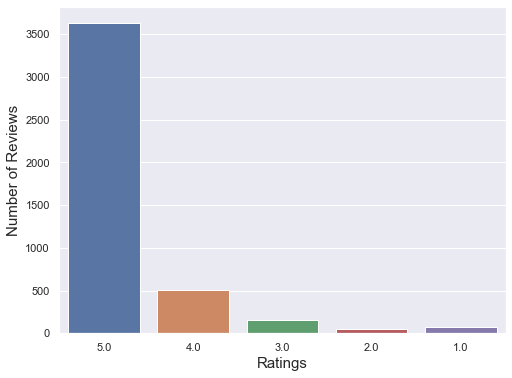

In [118]:
# set size of figure 
plt.figure(figsize=(8,6))
# set colour scheme
sns.set(style='darkgrid')
# make plot
sns.countplot(df['rating'].sort_values(ascending= False))
# set labels
plt.xlabel("Ratings", size=15)
plt.ylabel("Number of Reviews", size=15)
plt.show()

The plot above shows that more than half of the total customer reviews have rated the hotel 5 stars. I will assume 3 stars and below is a bad review and 4-5 stars is a good review. It would be interesting to identify some of the key things that resulted in a bad review. 

In [39]:
#convert the rating data type into a float figures
df['rating'] = df['rating'].astype(float)
#checking this converterd
df['rating'].dtype

dtype('float64')

In [45]:
#Categorising the rating column 
df["rating_cats"] = pd.cut(df['rating'] , bins=[0,3,5], labels=['Poor ratings','Good ratings'])

In [67]:
total_poor_reviews = df.loc[df["rating_cats"] == "Poor ratings"]

In [92]:
total_good_reviews = df.loc[df["rating_cats"] == "Good ratings"]

## 1a. Word Cloud visualisation

In [88]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [48]:
pd.set_option('display.max_colwidth', -1)

In [84]:
from nltk.corpus import wordnet

# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#function used to clean text
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [56]:
reviews_df = df['review'].copy()

In [143]:
# clean text data
reviews_df["review_clean"] = df["review"].apply(lambda x: clean_text(x))

In [144]:
reviews_df["review_clean"][:5]

0    [stay, sunday, night, whole, experience, magical.even, covid, change, follow, max, beautiful, decor,throughout.fabulous, cocktail, rivoli, bar, food, delicious.we, treat, beef, wellington-sublime, staff, friendly, helpful, discrete.coming, reception, chance, upon, executive, chef, mr, john, williams, mbe, head, concierge, mr, michael, de, cozar, discuss, work, issue.i, confess, overcome, see, well, know, people, stop, discuss, sort, work, quick, chat, hotel, kitchen, lovely, gesture, guest's, make, feel, nothing, much, trouble, inconvenience, afternoon, tea, delight.do, dress, wear, tie, palm, court, make, feel, special, thank, everyone, lovely, stay, back]                                                                                                          
1    [amaze, dinner, attentive, waiter, excellent, food, breakfast, also, good, bedroom, anti, covid, standard, comfortable, staff, attentive, unobtrusive, italian, garden, well, worth, visit, drink, even, afternoon, tea]  

In [90]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

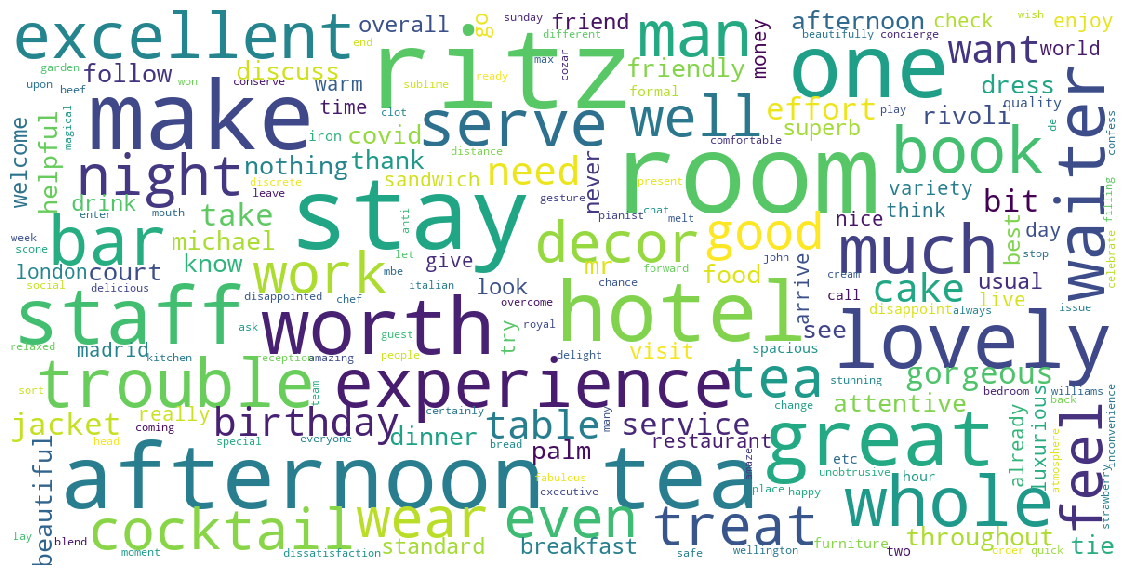

In [59]:
#using word cloud to display the popular/most frequent words in the reviews

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review_clean"])

The results from the wordcloud show the most frequent words that appaear in the reviews and these represent a broad view of the hotel related attributes that guests are most relevant to hotel guests. 

In [87]:
# apply word cloud on reviews categorised as poor ratings

#create new data frame
poor_reviews_df = total_poor_reviews['review'].copy()

#convert series to data frame 
poor_reviews_df = pd.DataFrame(poor_reviews_df)

# clean text data applying function created above
poor_reviews_df['review_clean'] = poor_reviews_df["review"].apply(lambda x: clean_text(x))

#view clean text
poor_reviews_df['review_clean'][:20]

10     afternoon tea ritz hotel disaster start finish...
19     afternoon tea ritz.......this huge treat famil...
22     book afternoon tea treat husband's birthday fi...
27     watch programme tv high tea ritz customer king...
38     main part hotel retain charm glamour shock sta...
48     tried get drink bar ritz smartly dress middle ...
60     full day travel family head ritz refreshment p...
76     arrange car collect airport luigi driver drive...
78     sadly place tourist attraction americans chine...
80     use key rival claridge’s cut dorchester savoy ...
87     stay night january list while.the welcome frie...
123    book one night stay ritz xmas treat arrive che...
125    drop drink enjoy ambiance place great time use...
126    stay last couple year xmas out london last yea...
131    wait month book finally stay ritz special trea...
139    thing go london ritz location nothing worth ov...
143    watch programme christmas decoration ritz deci...
147    give eye water cost even

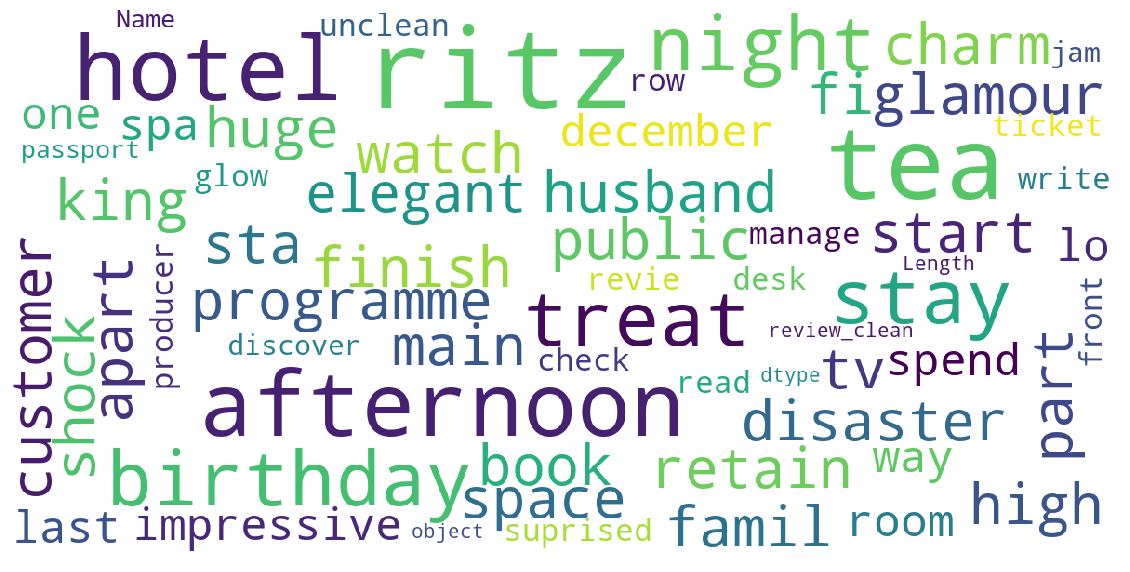

In [91]:
# visualise wordcloud
show_wordcloud(poor_reviews_df['review_clean'])

In [93]:
# apply word cloud on reviews categorised as good ratings

#create new data frame
good_reviews_df = total_good_reviews['review'].copy()

#convert series to data frame 
good_reviews_df = pd.DataFrame(good_reviews_df)

# clean text data applying function created above
good_reviews_df['review_clean'] = good_reviews_df["review"].apply(lambda x: clean_text(x))

#view clean text
good_reviews_df['review_clean'][:20]

0     stay sunday night whole experience magical.eve...
1     amaze dinner attentive waiter excellent food b...
2     stay week wish won’t much dissatisfaction over...
3     celebrate friend birthday go ritz afternoon te...
4     stay ritz one night queen room standard one af...
5     sunday lunch ritz three course glass champagne...
6     celebrate special birthday lunch ritz special ...
7     experience simple perfection staff friendly pr...
8     wife stay ritz london amazing hotel perfect to...
9     half surprise champagne evening afternoon tea ...
11    expect another beautiful afternoon spend ritz ...
12    grand surroundings overall enjoyable experienc...
13    visit champagne afternoon tea excellent time a...
14    stay night dinner absolutely fabulous well wor...
15    start finish experience must like gold standar...
16    mother afternoon tea could fault part sandwich...
17    thoroughly enjoy champagne afternoon tea today...
18    finally afternoon tea originally book may 

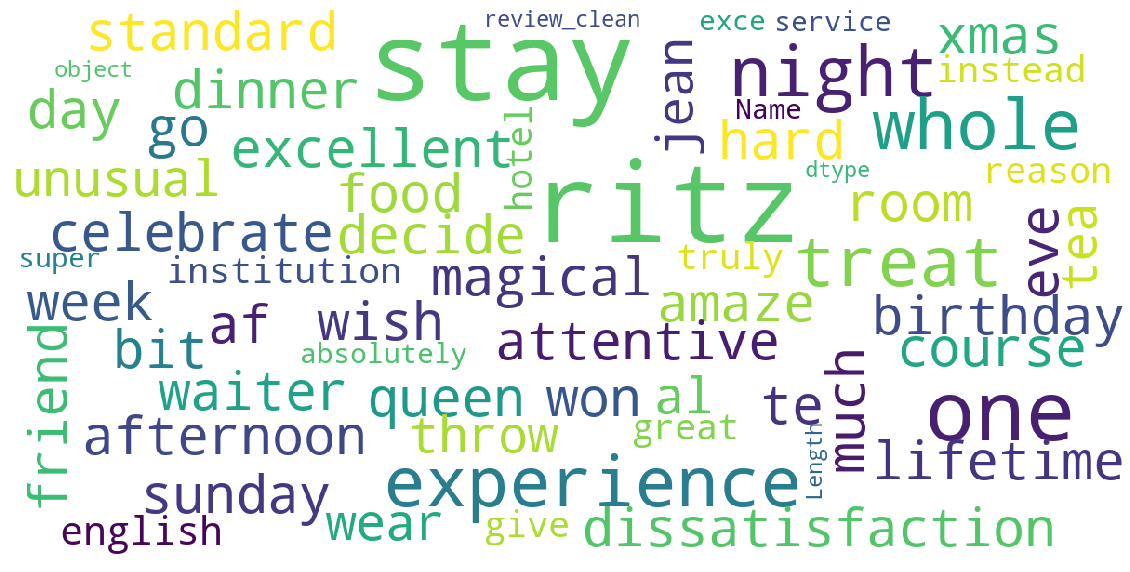

In [94]:
# visualise wordcloud
show_wordcloud(good_reviews_df['review_clean'])

## 2. Topic Modelling 
Topic modelling is applied on all reviews data

In [103]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

/anaconda3/envs/spacy/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [106]:
#function used to clean text
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    #text = " ".join(text)
    return(text)

In [107]:
# clean text data
processed_docs = df["review"].apply(lambda x: clean_text(x))

In [136]:
# Apply topic modelling on all reviews data

In [108]:
# Create Dictionary
id2word = corpora.Dictionary(processed_docs)

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

# View
print(corpus[:20])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2)], [(0, 1), (13, 1), (27, 1), (58, 1), (62, 1), (69, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)], [(46, 1), (59, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (10

In [150]:
#build lda model with 2 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.025*"tea" + 0.016*"afternoon" + 0.014*"ritz" + 0.013*"experience" + 0.012*"staff" + 0.011*"cake" + 0.011*"service" + 0.011*"birthday" + 0.010*"food" + 0.008*"special"'),
 (1,
  '0.025*"room" + 0.022*"hotel" + 0.018*"ritz" + 0.017*"stay" + 0.009*"service" + 0.009*"staff" + 0.008*"one" + 0.007*"night" + 0.007*"london" + 0.006*"would"')]

In [151]:
#save the model 
lda_model.save("lda_2_topics.model")

In [109]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_2_topics.model")

/anaconda3/envs/spacy/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [110]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.083136  0.0       1        1  56.974335
0     -0.083136  0.0       2        1  43.025665, topic_info=          Term         Freq        Total Category  logprob  loglift
62         tea  3132.000000  3132.000000  Default  30.0000  30.0000
0    afternoon  1848.000000  1848.000000  Default  29.0000  29.0000
59        stay  2618.000000  2618.000000  Default  28.0000  28.0000
33       hotel  3505.000000  3505.000000  Default  27.0000  27.0000
120       cake  1157.000000  1157.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
90       visit   437.989136   769.583191   Topic2  -5.5216   0.2797
86        good   451.617371  1112.419434   Topic2  -5.4910  -0.0581
96       great   437.415100  1047.581543   Topic2  -5.5229  -0.0300
141       like   431.914703  1153.648804   Topic2  -5.5356  -0.1391
211       room   450.327057  3903.377686   Topic2  -5.4938  -1.3163

[192 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2101      1  0.975621     access
2101      2  0.023229     access
0         1  0.030828  afternoon
0         2  0.969184  afternoon
765       1  0.982097    amenity
...     ...       ...        ...
218       2  0.654239  wonderful
281       1  0.885141      world
281       2  0.114438      world
176       1  0.549307      would
176       2  0.450262      would

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

Based on the results from the lda model, the topics can be categorised as follows:
1. Afternoon tea
2. Hotel stay


In [111]:
# build lda model with 4 topics
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda_model_2.print_topics()

[(0,
  '0.032*"tea" + 0.019*"afternoon" + 0.013*"ritz" + 0.013*"cake" + 0.013*"birthday" + 0.012*"experience" + 0.011*"staff" + 0.009*"lovely" + 0.009*"service" + 0.008*"go"'),
 (1,
  '0.024*"hotel" + 0.018*"ritz" + 0.018*"room" + 0.016*"stay" + 0.008*"go" + 0.008*"one" + 0.007*"london" + 0.007*"would" + 0.007*"like" + 0.007*"get"'),
 (2,
  '0.024*"room" + 0.022*"hotel" + 0.021*"ritz" + 0.019*"stay" + 0.015*"staff" + 0.015*"service" + 0.008*"night" + 0.008*"experience" + 0.008*"one" + 0.008*"breakfast"'),
 (3,
  '0.029*"room" + 0.007*"check" + 0.007*"bathroom" + 0.006*"hotel" + 0.006*"good" + 0.005*"ritz" + 0.005*"take" + 0.005*"one" + 0.005*"nice" + 0.005*"would"')]

In [112]:
#save the model 
lda_model_2.save("lda_4_topics.model")

/anaconda3/envs/spacy/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/anaconda3/envs/spacy/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [113]:
#loading the model
lda_model_2 = gensim.models.ldamodel.LdaModel.load("lda_4_topics.model")

/anaconda3/envs/spacy/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/anaconda3/envs/spacy/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [114]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.061401 -0.038039       1        1  39.827824
0     -0.138125  0.071438       2        1  36.273727
1      0.036520 -0.102590       3        1  17.851490
3      0.163005  0.069190       4        1   6.046958, topic_info=          Term         Freq        Total Category  logprob  loglift
211       room  3959.000000  3959.000000  Default  30.0000  30.0000
62         tea  3202.000000  3202.000000  Default  29.0000  29.0000
0    afternoon  1918.000000  1918.000000  Default  28.0000  28.0000
33       hotel  3649.000000  3649.000000  Default  27.0000  27.0000
120       cake  1215.000000  1215.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
79   breakfast    49.752350  1029.918213   Topic4  -5.7345  -0.2246
59        stay    57.793350  2781.000488   Topic4  -5.5847  -1.0681
508       give    44.785961   584.779114   Topic4  -5.8397   0.2363
437        say    46.596600   877.558838   Topic4  -5.8000  -0.1300
117       book    44.344284  1062.738037   Topic4  -5.8496  -0.3710

[372 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3103      1  0.981393  accommodation
4654      1  0.982277        achieve
0         1  0.055770      afternoon
0         2  0.936097      afternoon
0         3  0.004691      afternoon
...     ...       ...            ...
176       3  0.192694          would
176       4  0.042953          would
961       1  0.029841           xmas
961       2  0.969821           xmas
1930      2  0.965959          yummy

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

The results from the above lda model do not give a clear distinction of topics, therefore i will assume there are only two clear topics as discovered from the first model. 

## Conclusion

I extracted over 4000 customer reviews from Tripadvisor from the Ritz hotel in London. It was observed that over the reviews were heavily skewed with ratings of 5 stars. 

The reviews were subdivided into two groups based on the ratings:
- Good ratings: This consists of 5 and 4 star ratings
- Poor ratings: This consists of 3 star ratings and less

The good ratings consisted of customers praising the following: room service, hotel staff, hotel experience, afternoon tea. The poor ratings consisted of customers discussing afternoon tea, family room, space, birthday within their reviews. 

LDA was undertaken to determine the key topics discussed in the reviews. The results showed that customers were primarily reviewing two main topics:
- Afternoon Tea
- Hotel experience 

It can be concluded that according to the reviews customers generally rate their experience at the Ritz quite high above 4stars. Customers also generally come to the Ritz for holidays and to celebrate special occasions with their afternoon tea service. 